# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://docs.langchain.com/oss/python/concepts/memory#profile) or [collection](https://docs.langchain.com/oss/python/concepts/memory#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to pull together the pieces we've learned to build an agent with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

The chatbots we built previously *always* reflected on the conversation and saved memories. 

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection. 

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items. 

In [63]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [64]:
# import os, getpass

# def _set_env(var: str):
#     # Check if the variable is set in the OS environment
#     env_value = os.environ.get(var)
#     if not env_value:
#         # If not set, prompt the user for input
#         env_value = getpass.getpass(f"{var}: ")
    
#     # Set the environment variable for the current process
#     os.environ[var] = env_value

# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

import boto3
import os

try:
    # This attempts to connect to AWS using the loaded environment variables
    sts = boto3.client('sts')
    identity = sts.get_caller_identity()
    print("✅ Credentials are valid!")
    print(f"Account: {identity['Account']}")
    print(f"ARN: {identity['Arn']}")
except Exception as e:
    print("❌ Credentials failed.")
    print(e)

✅ Credentials are valid!
Account: 613468529489
ARN: arn:aws:iam::613468529489:user/ai_developper_juanse


In [65]:
import os
import getpass
from dotenv import load_dotenv

# 1. Load environment variables from the .env file
# This reads your .env file and loads variables into os.environ
load_dotenv()

def _set_env(var: str):
    # Check if the variable is set in the OS environment (including those loaded by .env)
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

# 2. Ensure AWS credentials are set
# If they are in your .env file, they will be used automatically.
# If not, you will be prompted to enter them.
_set_env("AWS_ACCESS_KEY_ID")
_set_env("AWS_SECRET_ACCESS_KEY")
_set_env("AWS_DEFAULT_REGION") # e.g., us-east-1

# Optional: If you are using temporary credentials (SSO), uncomment the line below:
# _set_env("AWS_SESSION_TOKEN") 

# 3. LangSmith Configuration (from your example)
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

print("✅ Environment setup complete.")

✅ Environment setup complete.


## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.

What if we want visibility into the *specific changes* made by Trustcall?

For example, we saw before that Trustcall has some of its own tools to:

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

Below, we'll show how to do this!

In [66]:
# from pydantic import BaseModel, Field

# class Memory(BaseModel):
#     content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# class MemoryCollection(BaseModel):
#     memories: list[Memory] = Field(description="A list of memories about the user.")

import uuid
from typing import Optional

from pydantic import BaseModel, Field, model_validator

class Memory(BaseModel):
    id: str = Field(default="", description="Unique identifier for the memory.")
    content: str = Field(description="The main content of the memory.")
    
    @model_validator(mode='after')
    def ensure_id(self) -> 'Memory':
        # Si el LLM dejó el ID vacío o intentó inventar uno corto/inválido
        if not self.id or len(self.id) < 10:
            self.id = str(uuid.uuid4())
        return self

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) <!-- broken, but cannot find better linke --> to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

Our `Spy` class will extract information about what tool calls were made by Trustcall.

In [67]:
# from langchain_openai import ChatOpenAI
from langchain_aws import ChatBedrockConverse
from dotenv import load_dotenv

load_dotenv('/home/juansebas7ian/langchain-academy/.env')

# 1. CONFIGURACIÓN PARA DEEPSEEK-R1 (Razonamiento Complejo)
llm_deepseek_r1 = ChatBedrockConverse(
    model="us.deepseek.r1-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=8192,
    top_p=0.95,
)

# 2. CONFIGURACIÓN PARA DEEPSEEK-V3
llm_deepseek_v3 = ChatBedrockConverse(
    model="us.deepseek.v3-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=4096,
)

# 3. CONFIGURACIÓN PARA LLAMA 4 SCOUT
llm_scout = ChatBedrockConverse(
    model="us.meta.llama4-scout-17b-instruct-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# 4. CONFIGURACIÓN PARA LLAMA 4 MAVERICK
llm_maverick = ChatBedrockConverse(
    model="us.meta.llama4-maverick-17b-instruct-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# 5. CONFIGURACIÓN PARA AMAZON NOVA LITE
llm_nova2_lite = ChatBedrockConverse(
    model="us.amazon.nova-2-lite-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)



# 5. CONFIGURACIÓN PARA AMAZON NOVA LITE
llm_nova_lite = ChatBedrockConverse(
    model="amazon.nova-lite-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)


# 6. CONFIGURACIÓN PARA AMAZON NOVA MICRO
llm_nova_micro = ChatBedrockConverse(
    model="amazon.nova-micro-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# 7. CONFIGURACIÓN PARA AMAZON NOVA PRO
llm_nova_pro = ChatBedrockConverse(
    model="amazon.nova-pro-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# Seleccionar el LLM activo
model = llm_nova2_lite

from trustcall import create_extractor
# from langchain_openai import ChatOpenAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)

# # Create the extractor
# trustcall_extractor = create_extractor(
#     model,
#     tools=[Memory],
#     tool_choice="Memory",
#     enable_inserts=True,
# )

# Re-inicializamos el extractor
trustcall_extractor = create_extractor(
    model, # Tu modelo Nova Pro
    tools=[MemoryCollection], # <--- AQUÍ ESTÁ LA CLAVE
    tool_choice="MemoryCollection",
    enable_inserts=True,
)


# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [68]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [69]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'MemoryCollection', 'input': {'memories': [{'content': 'Lance had a nice bike ride in San Francisco this morning.'}]}, 'id': 'tooluse_--A6zDCYQlyHMa3yVE6Yog'}]
Tool Calls:
  MemoryCollection (tooluse_--A6zDCYQlyHMa3yVE6Yog)
 Call ID: tooluse_--A6zDCYQlyHMa3yVE6Yog
  Args:
    memories: [{'content': 'Lance had a nice bike ride in San Francisco this morning.'}]


In [70]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

memories=[Memory(id='d3781dfa-11f5-4bf4-99ae-8201d92a77cb', content='Lance had a nice bike ride in San Francisco this morning.')]


In [71]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'tooluse_--A6zDCYQlyHMa3yVE6Yog'}


In [72]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# 1. Obtenemos la respuesta cruda
raw_response = result["responses"]

# 2. Lógica inteligente para detectar qué tenemos
if raw_response and isinstance(raw_response[0], MemoryCollection):
    # CASO A: Ya es una colección (lo que te pasó a ti)
    # Simplemente tomamos el primer elemento, no hace falta envolverlo de nuevo
    print("✅ Se detectó una colección existente.")
    current_collection = raw_response[0]
else:
    # CASO B: Son memorias sueltas (la primera vez que corres el script)
    # Las empaquetamos en una nueva colección
    print("✅ Se detectaron memorias sueltas. Creando colección...")
    current_collection = MemoryCollection(memories=raw_response)

# 3. Ahora sí preparamos el existing_memories sin errores
tool_name = "MemoryCollection"
existing_memories = [("0", tool_name, current_collection.model_dump())]

# Verificación
print("\nEstructura lista para Trustcall:")
print(existing_memories)

✅ Se detectó una colección existente.

Estructura lista para Trustcall:
[('0', 'MemoryCollection', {'memories': [{'id': 'd3781dfa-11f5-4bf4-99ae-8201d92a77cb', 'content': 'Lance had a nice bike ride in San Francisco this morning.'}]})]


In [73]:
# Update the conversation
updated_conversation = [HumanMessage(content="Continue extracting memories from this conversation:"),
                        AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]
# Update the instruction
# system_msg = """Update existing memories and create new ones based on the following conversation:"""
system_msg = """You are a memory extraction assistant. Your task is to extract ALL distinct facts and memories from the user's messages in the conversation.

RULES:
1. Extract EVERY piece of information the user shares (activities, places, plans, preferences).
2. Each memory should be a complete, standalone fact.
3. Do NOT skip any user-provided details.
4. Do NOT split a single statement into multiple memories.
5. Do NOT merge unrelated facts into one memory.

For updates:
- Preserve existing memories unless they are factually incorrect.
- Add new memories for new information.
"""
# We'll save existing memories, giving them an ID, key (tool name), and value
# tool_name = "Memory"
# existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
# existing_memories

# Invocamos
result_collection = trustcall_extractor_see_all_tool_calls.invoke({
    "messages": [SystemMessage(content=system_msg)] + updated_conversation, 
    "existing": existing_memories
})

#Verificamos el resultado
print("--- RESULTADO FINAL ---")
for r in result_collection["responses"]:
    # Esto imprimirá un objeto MemoryCollection que contiene TODAS las memorias (viejas + nuevas)
    print(r)



--- RESULTADO FINAL ---
memories=[Memory(id='d3781dfa-11f5-4bf4-99ae-8201d92a77cb', content='Lance had a nice bike ride in San Francisco this morning.'), Memory(id='956ff3e4-f192-474a-aa8b-8b981bcd68c5', content='The user went to Tartine and ate a croissant.'), Memory(id='c6da57cf-c3a1-467b-abb8-47e7cd09df79', content='The user is thinking about going back to Japan this winter!')]


In [74]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [75]:
# Metadata contains the tool call  
# for m in result["response_metadata"]: 
#     print(m)

# # Opción 2: Mostrar los IDs de cada memoria en la colección
for response in result_collection["responses"]:
    if hasattr(response, 'memories'):  # Si es una MemoryCollection
        for memory in response.memories:
            print(f"Memory ID: {memory.id}, Content: {memory.content}")
    else:
        print(response)  # Si es un objeto Memory individual

Memory ID: d3781dfa-11f5-4bf4-99ae-8201d92a77cb, Content: Lance had a nice bike ride in San Francisco this morning.
Memory ID: 956ff3e4-f192-474a-aa8b-8b981bcd68c5, Content: The user went to Tartine and ate a croissant.
Memory ID: c6da57cf-c3a1-467b-abb8-47e7cd09df79, Content: The user is thinking about going back to Japan this winter!


In [76]:
# Ejecuta esto para ver qué guardó realmente dentro de esa única llamada
for r in result_collection["responses"]:
    print(r)

memories=[Memory(id='d3781dfa-11f5-4bf4-99ae-8201d92a77cb', content='Lance had a nice bike ride in San Francisco this morning.'), Memory(id='956ff3e4-f192-474a-aa8b-8b981bcd68c5', content='The user went to Tartine and ate a croissant.'), Memory(id='c6da57cf-c3a1-467b-abb8-47e7cd09df79', content='The user is thinking about going back to Japan this winter!')]


In [77]:
# Messages contain the tool calls
for m in result_collection["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'PatchDoc', 'input': {'json_doc_id': '0', 'planned_edits': 'Add two new memories: 1) the user went to Tartine and ate a croissant, 2) the user is thinking about going back to Japan this winter', 'patches': [{'op': 'add', 'path': '/memories/-', 'value': {'content': 'The user went to Tartine and ate a croissant.'}}, {'op': 'add', 'path': '/memories/-', 'value': {'content': 'The user is thinking about going back to Japan this winter!'}}]}, 'id': 'tooluse_Al9PbmD_RF-btk56YYFihA'}]
Tool Calls:
  MemoryCollection (tooluse_Al9PbmD_RF-btk56YYFihA)
 Call ID: tooluse_Al9PbmD_RF-btk56YYFihA
  Args:
    memories: [{'id': 'd3781dfa-11f5-4bf4-99ae-8201d92a77cb', 'content': 'Lance had a nice bike ride in San Francisco this morning.'}, {'content': 'The user went to Tartine and ate a croissant.'}, {'content': 'The user is thinking about going back to Japan this winter!'}]


In [78]:
for m in result["responses"]:
    if hasattr(m, 'memories'):
        for mem in m.memories:
            print(f"ID: {mem.id}, Content: {mem.content}")

ID: d3781dfa-11f5-4bf4-99ae-8201d92a77cb, Content: Lance had a nice bike ride in San Francisco this morning.
ID: 35e2888b-dd12-42c2-9c15-d43b513751ca, Content: I went to Tartine and ate a croissant.
ID: 14b78796-1bcf-4eaf-9fa7-5046ac4bb79f, Content: I was thinking about my Japan, and going back this winter!


In [79]:
# Parsed responses
for m in result_collection["responses"]:
    print(m)

memories=[Memory(id='d3781dfa-11f5-4bf4-99ae-8201d92a77cb', content='Lance had a nice bike ride in San Francisco this morning.'), Memory(id='956ff3e4-f192-474a-aa8b-8b981bcd68c5', content='The user went to Tartine and ate a croissant.'), Memory(id='c6da57cf-c3a1-467b-abb8-47e7cd09df79', content='The user is thinking about going back to Japan this winter!')]


In [80]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Add two new memories: 1) the user went to Tartine and ate a croissant, 2) the user is thinking about going back to Japan this winter',
    'patches': [{'op': 'add',
      'path': '/memories/-',
      'value': {'content': 'The user went to Tartine and ate a croissant.'}},
     {'op': 'add',
      'path': '/memories/-',
      'value': {'content': 'The user is thinking about going back to Japan this winter!'}}]},
   'id': 'tooluse_Al9PbmD_RF-btk56YYFihA',
   'type': 'tool_call'}],
 [{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Add two new memories to the existing MemoryCollection instance. The first memory is about the user going to Tartine and eating a croissant. The second memory is about the user thinking about going back to Japan this winter.',
    'patches': [{'op': 'add',
      'path': '/memories/-',
      'value': {'content': 'I went to Tartine and ate a croissant.'}},
     {'

In [81]:
# def extract_tool_info(tool_calls, schema_name="Memory"):
#     """Extract information from tool calls for both patches and new memories.
    
#     Args:
#         tool_calls: List of tool calls from the model
#         schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
#     """

#     # Initialize list of changes
#     changes = []
    
#     for call_group in tool_calls:
#         for call in call_group:
#             if call['name'] == 'PatchDoc':
#                 changes.append({
#                     'type': 'update',
#                     'doc_id': call['args']['json_doc_id'],
#                     'planned_edits': call['args']['planned_edits'],
#                     'value': call['args']['patches'][0]['value']
#                 })
#             elif call['name'] == schema_name:
#                 changes.append({
#                     'type': 'new',
#                     'value': call['args']
#                 })

#     # Format results as a single string
#     result_parts = []
#     for change in changes:
#         if change['type'] == 'update':
#             result_parts.append(
#                 f"Document {change['doc_id']} updated:\n"
#                 f"Plan: {change['planned_edits']}\n"
#                 f"Added content: {change['value']}"
#             )
#         else:
#             result_parts.append(
#                 f"New {schema_name} created:\n"
#                 f"Content: {change['value']}"
#             )
    
#     return "\n\n".join(result_parts)

# # Inspect spy.called_tools to see exactly what happened during the extraction
# schema_name = "Memory"
# changes = extract_tool_info(spy.called_tools, schema_name)
# print(changes)

def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                # CAMBIO 1: Guardamos la lista completa de parches, no solo el primero
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args'].get('planned_edits', 'No plan provided'),
                    'patches': call['args']['patches'] # Guardamos toda la lista
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            # CAMBIO 2: Iteramos sobre los parches para formatear cada cambio individualmente
            patches_formatted = []
            for p in change['patches']:
                op = p.get('op', 'unknown')
                path = p.get('path', '')
                val = p.get('value', '')
                patches_formatted.append(f"   - [{op}] {path}: {val}")
            
            patches_str = "\n".join(patches_formatted)
            
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Changes applied:\n{patches_str}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Prueba con tu spy
# Nota: schema_name debe coincidir con el nombre de la herramienta si se crea una nueva, 
# pero para PatchDoc (actualizaciones) el nombre es irrelevante.
schema_name = "MemoryCollection" 
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: Add two new memories: 1) the user went to Tartine and ate a croissant, 2) the user is thinking about going back to Japan this winter
Changes applied:
   - [add] /memories/-: {'content': 'The user went to Tartine and ate a croissant.'}
   - [add] /memories/-: {'content': 'The user is thinking about going back to Japan this winter!'}

Document 0 updated:
Plan: Add two new memories to the existing MemoryCollection instance. The first memory is about the user going to Tartine and eating a croissant. The second memory is about the user thinking about going back to Japan this winter.
Changes applied:
   - [add] /memories/-: {'content': 'I went to Tartine and ate a croissant.'}
   - [add] /memories/-: {'content': 'I was thinking about my Japan, and going back this winter!'}


## Creating an agent

There are many different agent architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://docs.langchain.com/oss/python/langgraph/workflows-agents#agents) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [82]:
from typing import TypedDict, Literal

# Update memory tool
# class UpdateMemory(TypedDict):
#     """ Decision on what memory type to update """
#     update_type: Literal['user', 'todo', 'instructions']

class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    reasoning: str  # <--- AÑADIR: Mejora la calidad de las decisiones del modelo
    update_type: Literal['user', 'todo', 'instructions']

In [83]:
# _set_env("OPENAI_API_KEY")

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

/tmp/ipykernel_58411/427339677.py:127: PydanticDeprecatedSince20: `min_items` is deprecated and will be removed, use `min_length` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  solutions: list[str] = Field(


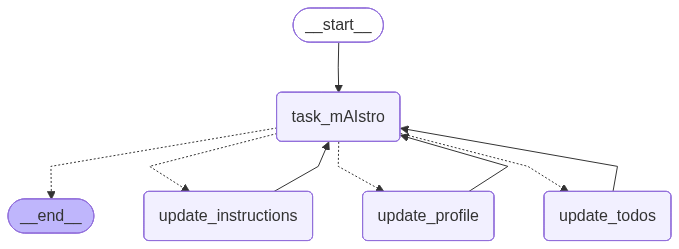

In [84]:
from langchain_aws import ChatBedrockConverse
from dotenv import load_dotenv

load_dotenv('/home/juansebas7ian/langchain-academy/.env')

# 1. CONFIGURACIÓN PARA DEEPSEEK-R1 (Razonamiento Complejo)
llm_deepseek_r1 = ChatBedrockConverse(
    model="us.deepseek.r1-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=8192,
    top_p=0.95,
)

# 2. CONFIGURACIÓN PARA DEEPSEEK-V3
llm_deepseek_v3 = ChatBedrockConverse(
    model="us.deepseek.v3-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=4096,
)

# 3. CONFIGURACIÓN PARA LLAMA 4 SCOUT
llm_scout = ChatBedrockConverse(
    model="us.meta.llama4-scout-17b-instruct-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# 4. CONFIGURACIÓN PARA LLAMA 4 MAVERICK
llm_maverick = ChatBedrockConverse(
    model="us.meta.llama4-maverick-17b-instruct-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# 5. CONFIGURACIÓN PARA AMAZON NOVA LITE
llm_nova2_lite = ChatBedrockConverse(
    model="us.amazon.nova-2-lite-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)



# 5. CONFIGURACIÓN PARA AMAZON NOVA LITE
llm_nova_lite = ChatBedrockConverse(
    model="amazon.nova-lite-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)


# 6. CONFIGURACIÓN PARA AMAZON NOVA MICRO
llm_nova_micro = ChatBedrockConverse(
    model="amazon.nova-micro-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# 7. CONFIGURACIÓN PARA AMAZON NOVA PRO
llm_nova_pro = ChatBedrockConverse(
    model="amazon.nova-pro-v1:0",
    region_name="us-east-1",
    temperature=0.0,
    max_tokens=2048,
    top_p=0.9,
)

# Seleccionar el LLM activo
model = llm_nova2_lite

import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

# from langchain_openai import ChatOpenAI

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory] #, parallel_tool_calls=False # Bedrock Converse does not support this parameter
    ).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
        # Extract detailed changes using the spy\n    profile_update_msg = extract_tool_info(spy.called_tools, tool_name)\n    return {"messages": [{"role": "tool", "content": profile_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes

# =============================================================================
# 9. GRAPH CONSTRUCTION
# Assembles the nodes into a workflow.
# Configures the storage (MemoryStore) for long-term persistence.
# =============================================================================
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [85]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lance. I live in SF with my wife. I have a 1 year old daughter.
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UpdateMemory', 'input': {'update_type': 'user', 'reasoning': 'The user provided personal information about themselves: their name is Lance, they live in SF with their wife, and they have a 1 year old daughter. This information should be stored in the user profile.'}, 'id': 'tooluse_9XVbAHz3Qtqvii6xWlz3Iw'}]
Tool Calls:
  UpdateMemory (tooluse_9XVbAHz3Qtqvii6xWlz3Iw)
 Call ID: tooluse_9XVbAHz3Qtqvii6xWlz3Iw
  Args:
    update_type: user
    reasoning: The user provided personal information about themselves: their name is Lance, they live in SF with their wife, and they have a 1 year old daughter. This information should be stored in the user profile.
================================== Ai Message ==========================

In [86]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UpdateMemory', 'input': {'update_type': 'todo', 'reasoning': "The user's wife asked them to book swim lessons for their baby. This is a task that needs to be added to the user's ToDo list."}, 'id': 'tooluse_xbcfzhXjQL2DnMbonp-dgw'}]
Tool Calls:
  UpdateMemory (tooluse_xbcfzhXjQL2DnMbonp-dgw)
 Call ID: tooluse_xbcfzhXjQL2DnMbonp-dgw
  Args:
    update_type: todo
    reasoning: The user's wife asked them to book swim lessons for their baby. This is a task that needs to be added to the user's ToDo list.
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for baby', 'time_to_complete': 30, 'status': 'not started', 'solutions': ['Research local swim lessons for inf

In [87]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.


Tool messages (toolUse/toolResult) detected without toolConfig. Converting tool blocks to text format to avoid ValidationException.


================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UpdateMemory', 'input': {'update_type': 'instructions', 'reasoning': 'The user has specified a preference for when creating or updating ToDo items: they want specific local businesses/vendors to be included. This should be stored in the instructions memory.'}, 'id': 'tooluse_e3ik7AaLQKOJqz7KCaWrCg'}]
Tool Calls:
  UpdateMemory (tooluse_e3ik7AaLQKOJqz7KCaWrCg)
 Call ID: tooluse_e3ik7AaLQKOJqz7KCaWrCg
  Args:
    update_type: instructions
    reasoning: The user has specified a preference for when creating or updating ToDo items: they want specific local businesses/vendors to be included. This should be stored in the instructions memory.
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! When creating or updating ToDo items, I'll make su

In [88]:
# Check for updated instructions
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': '[Called UpdateMemory with parameters: {"update_type": "instructions", "reasoning": "The user wants ToDo items to include specific local businesses/vendors when creating or updating tasks. This is a new instruction that should be added to the current instructions.", "content": "When creating or updating ToDo items, include specific local businesses/vendors where applicable."}]'}


In [89]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UpdateMemory', 'input': {'update_type': 'todo', 'reasoning': "The user needs to fix a jammed electric Yale lock on their door. This is a task that should be added to their ToDo list. Since they've specified that ToDo items should include specific local businesses/vendors, I should include that in the solutions."}, 'id': 'tooluse_6shqbaMRSh6sF9cByd77OA'}]
Tool Calls:
  UpdateMemory (tooluse_6shqbaMRSh6sF9cByd77OA)
 Call ID: tooluse_6shqbaMRSh6sF9cByd77OA
  Args:
    update_type: todo
    reasoning: The user needs to fix a jammed electric Yale lock on their door. This is a task that should be added to their ToDo list. Since they've specified that ToDo items should include specific local businesses/vendors, I should include that in the solut

In [90]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for baby', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Research local swim lessons for infants in SF', 'Check availability and schedules', 'Contact providers to book'], 'status': 'not started'}
{'task': 'Fix jammed electric Yale lock on the door', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Call Yale Lock customer support for troubleshooting', 'Search for local locksmith services in SF specializing in Yale locks', "Check if there's a local Yale authorized service center in SF", 'Look for SF-based home security companies that service Yale locks'], 'status': 'not started'}


In [91]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UpdateMemory', 'input': {'update_type': 'todo', 'reasoning': 'The user has added a deadline for the swim lessons task - it needs to be done by the end of November. I should update the ToDo item to include this deadline.'}, 'id': 'tooluse_SvvlZLFVRouI8id8m_XjXA'}]
Tool Calls:
  UpdateMemory (tooluse_SvvlZLFVRouI8id8m_XjXA)
 Call ID: tooluse_SvvlZLFVRouI8id8m_XjXA
  Args:
    update_type: todo
    reasoning: The user has added a deadline for the swim lessons task - it needs to be done by the end of November. I should update the ToDo item to include this deadline.
================================= Tool Message =================================

Document 9bf91421-c08a-483c-abc5-be43f40fbdbc updated:
Plan: The user wants the swim less

We can see that Trustcall performs patching of the existing memory:

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r

In [92]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UpdateMemory', 'input': {'update_type': 'todo', 'reasoning': "The user wants to add a new task to call back City Toyota to schedule car service. Since they've specified that ToDo items should include specific local businesses/vendors, this task already includes a specific vendor (City Toyota), which is good. I need to add this as a new ToDo item."}, 'id': 'tooluse_ObTslphzQ9yzrF3fX74n5A'}]
Tool Calls:
  UpdateMemory (tooluse_ObTslphzQ9yzrF3fX74n5A)
 Call ID: tooluse_ObTslphzQ9yzrF3fX74n5A
  Args:
    update_type: todo
    reasoning: The user wants to add a new task to call back City Toyota to schedule car service. Since they've specified that ToDo items should include specific local businesses/vendors, this task already includes a specific 

In [93]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for baby', 'time_to_complete': 30, 'deadline': '2026-11-30T23:59:59Z', 'solutions': ['Research local swim lessons for infants in SF', 'Check availability and schedules', 'Contact providers to book'], 'status': 'not started'}
{'task': 'Fix jammed electric Yale lock on the door', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Call Yale Lock customer support for troubleshooting', 'Search for local locksmith services in SF specializing in Yale locks', "Check if there's a local Yale authorized service center in SF", 'Look for SF-based home security companies that service Yale locks'], 'status': 'not started'}
{'task': 'Call back City Toyota to schedule car service', 'time_to_complete': 15, 'deadline': None, 'solutions': ['Call City Toyota service department at their main location in SF', 'Ask about next available service appointment', 'Inquire about any required service for your vehicle make/model'], 'status': 'not started'}


Now we can create a new thread.

This creates a new session. 

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

In [94]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

Looking at your ToDo list, here are the tasks you can potentially complete in 30 minutes:

1. **"Book swim lessons for baby"** - This task is estimated to take 30 minutes to complete. The solutions include:
   - Researching local swim lessons for infants in SF
   - Checking availability and schedules
   - Contacting providers to book

2. **"Call back City Toyota to schedule car service"** - This task is estimated to take only 15 minutes to complete. The solutions include:
   - Calling City Toyota service department at their main location in SF
   - Asking about next available service appointment
   - Inquiring about any required service for your vehicle make/model

Both of these tasks fit within your 30-minute timeframe. The swim lessons task would use up your entire 30 minutes, 

In [95]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'UpdateMemory', 'input': {'update_type': 'todo', 'reasoning': "Updating the swim lessons task to include specific local businesses/vendors in SF as per the user's instruction. Adding concrete local options for swim lessons for infants in SF to the solutions list."}, 'id': 'tooluse_AV1Zp31dSt6CWFwQUSjS7A'}]
Tool Calls:
  UpdateMemory (tooluse_AV1Zp31dSt6CWFwQUSjS7A)
 Call ID: tooluse_AV1Zp31dSt6CWFwQUSjS7A
  Args:
    update_type: todo
    reasoning: Updating the swim lessons task to include specific local businesses/vendors in SF as per the user's instruction. Adding concrete local options for swim lessons for infants in SF to the solutions list.
================================= Tool Message =================================

Document 9bf91421

Trace: 

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r

## Studio

![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)